In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame, TwitterSearchTerm
import utils as ut

In [ ]:
# Get the health data from 2018 and agreggate.
health_files = os.listdir('../data/mendocino/data')
health_dfs = []
for f in health_files:
    health_dfs.append(pd.read_csv('../data/mendocino/data/'+f))
    
health_df = pd.concat(health_dfs)

In [ ]:
# Turn into a TwitterDataFrame
health_df = TwitterDataFrame(health_df)

In [14]:
ca_health_df = health_df.zoom_in((32,42),(-114,-125))

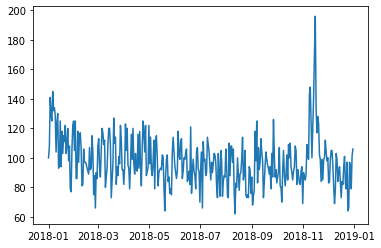

In [19]:
ca_health_df['created_at'] = [datetime.strptime(d,'%Y-%m-%dT%H:%M:%S.%fZ') for d in ca_health_df['created_at']]
plt.plot(ca_health_df.count_by_day())

In [ ]:
# Let's plot tweet counts about health against AQI

In [20]:
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

In [23]:
ca_aqi = aqi_2018[aqi_2018['State Name']=="California"]
mendocino = ca_aqi[ca_aqi['county Name']=="Mendocino"]

In [35]:
tweet_counts = ca_health_df.count_by_day()

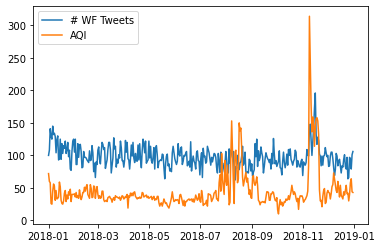

In [60]:
# Create a new data frame for looking at tweet counts and 
# AQI on the same graph

rows = []
for i, d in enumerate(mendocino['Date']):
    date = datetime.strptime(d,'%Y-%m-%d')
    try:
        count = tweet_counts.loc[date.date()]['id']
    except:
        count = 0
    aqi = mendocino['AQI'].iloc[i]
    
    rows.append([date, count, aqi])
    
new_df = pd.DataFrame(rows, columns=['date','tweets','aqi'])
plt.plot(new_df['date'],new_df['tweets'], label="# WF Tweets")
plt.plot(new_df['date'], new_df['aqi'], label="AQI")
plt.legend()

Text(0.5, 0, 'AQI')

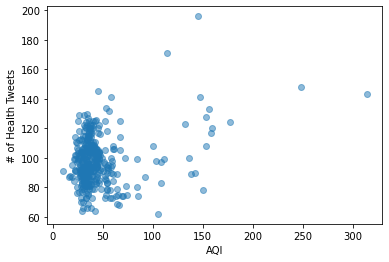

In [64]:
plt.scatter(new_df['aqi'],new_df['tweets'], alpha=0.5)
plt.ylabel("# of Health Tweets")
plt.xlabel("AQI")

Is there a more clear link between health tweets and AQI locally in Mendocino county?

In [72]:
mendocino_df = ca_health_df.zoom_in((38,41),(-121,-125))

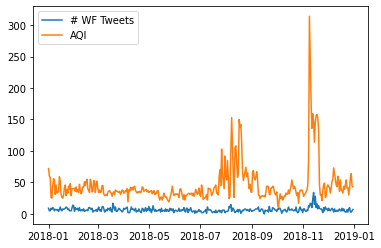

In [75]:
tweet_counts = mendocino_df.count_by_day()
rows = []
for i, d in enumerate(mendocino['Date']):
    date = datetime.strptime(d,'%Y-%m-%d')
    try:
        count = tweet_counts.loc[date.date()]['id']
    except:
        count = 0
    aqi = mendocino['AQI'].iloc[i]
    
    rows.append([date, count, aqi])
    
new_df = pd.DataFrame(rows, columns=['date','tweets','aqi'])
plt.plot(new_df['date'],new_df['tweets'], label="# WF Tweets")
plt.plot(new_df['date'], new_df['aqi'], label="AQI")
plt.legend()

Text(0.5, 0, 'AQI')

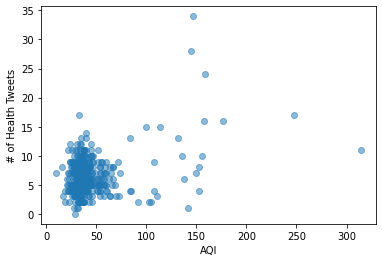

In [76]:
plt.scatter(new_df['aqi'],new_df['tweets'], alpha=0.5)
plt.ylabel("# of Health Tweets")
plt.xlabel("AQI")

# Let's instead look at how health topics trend during wildfire events in California

In [80]:
from nltk.tokenize import TweetTokenizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import re

In [81]:
cleaned_tweets = []
lemmatizer = WordNetLemmatizer()
tt = TweetTokenizer()
stopword_list = nltk.corpus.stopwords.words("english")
health_tweets = ca_health_df['text']
for tweet in health_tweets:
    t = tweet.lower()
#     t = remove_special_characters(t)
    t = tt.tokenize(t)
    t = [w for w in t if w.isalpha()]
    t = [lemmatizer.lemmatize(w) for w in t]
#     t = [w for w in t if w not in words_to_remove]
    cleaned_tweets.append(t)
# This is so we can pass this value into the count vectorizer
ct = [" ".join(t) for t in cleaned_tweets]

In [82]:
# Let's see how we can extract feature counts
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_df=.9, min_df=10)
termFrequency = cv.fit_transform(ct)
feature_names = cv.get_feature_names_out()

In [83]:
from sklearn.decomposition import LatentDirichletAllocation
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, random_state=42)

topic_assignment = lda.fit_transform(termFrequency)

In [84]:
for idx, topic in enumerate(lda.components_):
    print("Topic", idx," ".join(feature_names[i] for i in np.argsort(topic)[-20:]))

Topic 0 im work fuckin gotta oh nigga going ain man today bitch just god right really got fat rn worst headache
Topic 1 literally music damn got home love just sing song girl car breathe shit screaming wa singing feel fucking like lung
Topic 2 coffee getting today damn worst huge having gave big need night sleep giving just woke away got ve day headache
Topic 3 cause pretty did brain stop just coughing think game pain hot hit sure smoking like time trying make smoke lung
Topic 4 quality life leave drink water ve don like eat ha good fuck attack finally day want work breathe air asthma
Topic 5 body got wake eye killing sleep fever just feel hour nose hurt woke hate biggest sick bad sore throat headache
Topic 6 really minute didn shit going feeling barely hard year thought couldn time day today good feel just like wa breathe
Topic 7 thing make forget breath poor deep know tired free nose able live hard life time don need let just breathe
Topic 8 stupid better lol cover know like sneeze d

In [86]:
# Let's look at these topics over time
topics = np.argmax(topic_assignment, axis=1)
ca_health_df['topic'] = topics
topic_by_date = pd.pivot_table(ca_health_df, values="id",index='date',columns='topic', aggfunc='count',fill_value=0)
tbd = topic_by_date.reset_index()

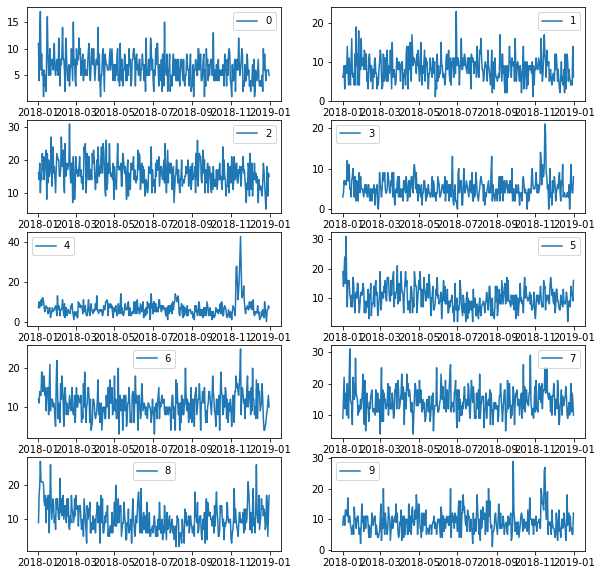

In [87]:
# plt.subplots(2, 5)
plt.figure(figsize=(10,10))
for i in range(0,10):
    plt.subplot(5,2, i+1)
    plt.plot(tbd['date'],tbd[i], label=i)
    plt.legend()

In [88]:
# How does the complexity still look?
print(lda.bound_)

814.1104812850666


In [95]:
from sklearn.decomposition import LatentDirichletAllocation
n_components = 40
lda = LatentDirichletAllocation(n_components=n_components, random_state=42)

topic_assignment = lda.fit_transform(termFrequency)

In [96]:
for idx, topic in enumerate(lda.components_):
    print("Topic", idx," ".join(feature_names[i] for i in np.argsort(topic)[-20:]))

Topic 0 really think bless head breathe guy chill shake trip enjoy today legit hella season right weekend play horrible headache going
Topic 1 word summer daughter pray mother sign sister screaming kid boy hearing little pls literally yelling headache breathe lung girl fucking
Topic 2 tight like tension lack late dumb stuffy pill drunk nose friday glass went allergy sleep bed haven woke night headache
Topic 3 break hit quit blunt rip time stop nah idk sitting heat cigarette weed face use cuz smoking lung trying smoke
Topic 4 ha tv acting rain good dust outside birthday lung asthma want fucked school fresh clean class quality happy breathe air
Topic 5 mood soooo feeling nauseous dealing allergy just sick runny running right tf itchy nose really eye biggest hate headache bad
Topic 6 everybody happening like happens chance holy news sigh gonna fell final relief day fall good asleep just second tomorrow breathe
Topic 7 peace thing rest calm make beautiful step day moment mind don forget br

In [97]:
# Let's look at these topics over time
topics = np.argmax(topic_assignment, axis=1)
ca_health_df['topic'] = topics
topic_by_date = pd.pivot_table(ca_health_df, values="id",index='date',columns='topic', aggfunc='count',fill_value=0)
tbd = topic_by_date.reset_index()

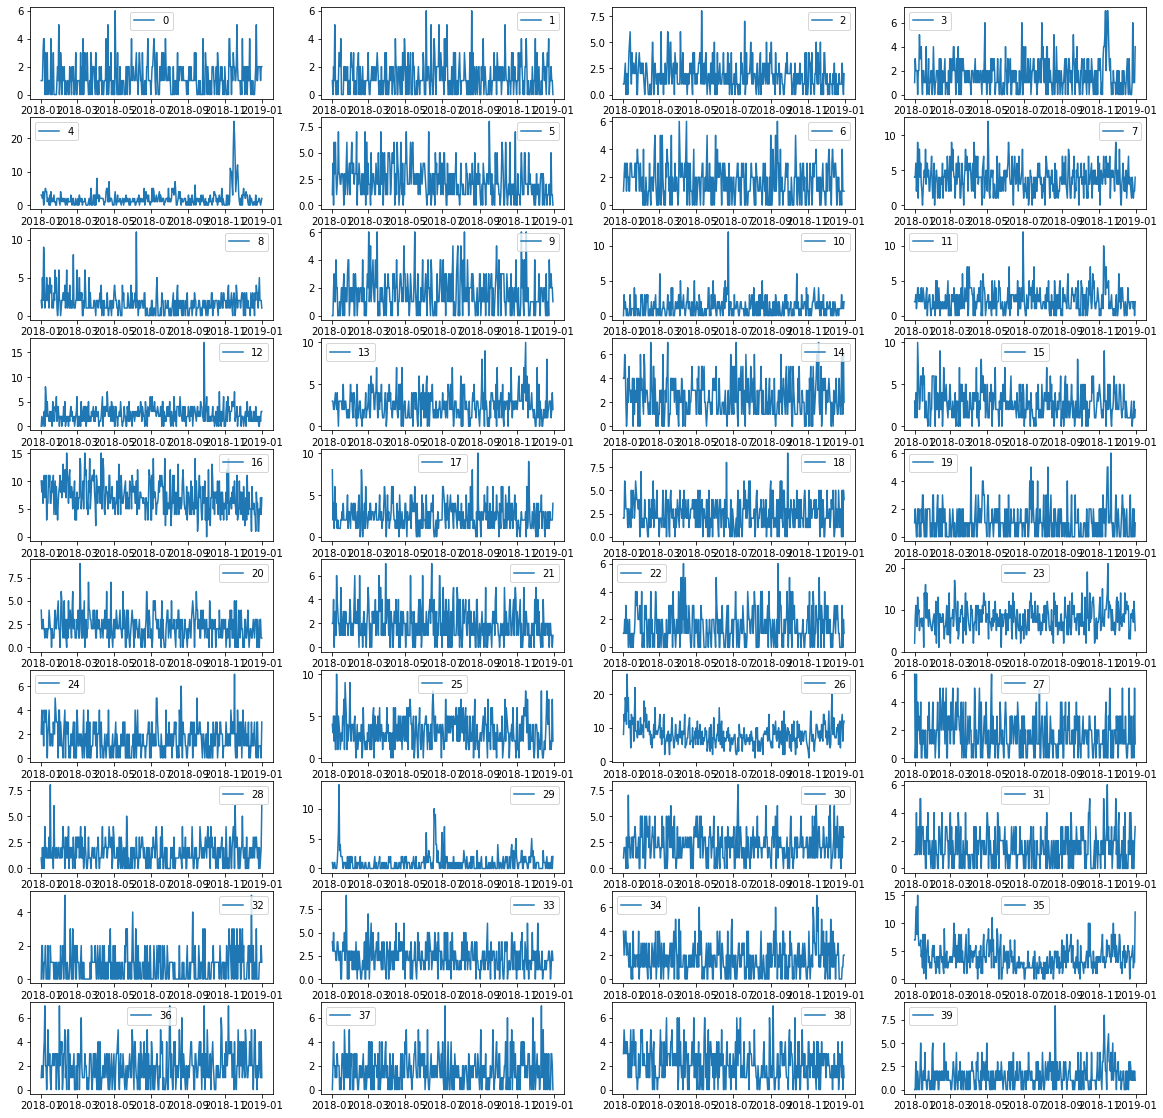

In [101]:
# plt.subplots(2, 5)
plt.figure(figsize=(20,20))
for i in range(0,40):
    plt.subplot(10,4, i+1)
    plt.plot(tbd['date'],tbd[i], label=i)
    plt.legend()

In [139]:
# How does the complexity still look?
print(lda.bound_)

1104.2074748707655


In [105]:
print(ca_health_df[ca_health_df['topic']==12]['text'])

76       Can we all collectively agree that screaming a...
91       @thehill It’s possible he is unable to breathe...
103      One time I was in the car with my friend and h...
168      Yesterday this man was on the floor outside hi...
374      Screaming Solange at the top of our lungs at 1...
                               ...                        
16798    One wish came on randomly on my way to Starbuc...
16983    Said no matter where I am, bless me with all y...
17044    I just left the gym and I pulled up next to so...
17084    Just played almost 2 hours of basketball... wi...
17150    I want to see banda MS and sing my lungs out a...
Name: text, Length: 890, dtype: object


In [136]:
def get_tweets(df, day, topic):
    topic_df = df[df['topic']==topic]
    return topic_df[topic_df['date']==day]['text']

In [116]:
df_12 = pd.pivot_table(ca_health_df[ca_health_df['topic']==12], values="id",index='date',columns='topic', aggfunc='count',fill_value=0)

In [126]:
df_12.sort_values(by=12, ascending=False)

topic,level_0,index,date,12
238,238,238,2018-09-27,17
4,4,4,2018-01-08,8
260,260,260,2018-10-22,7
281,281,281,2018-11-16,7
94,94,94,2018-04-20,7
...,...,...,...,...
82,82,82,2018-04-07,1
264,264,264,2018-10-27,1
39,39,39,2018-02-17,1
178,178,178,2018-07-24,1


In [138]:
for t in get_tweets(ca_health_df, datetime(2018,9,27).date(), 12):
    print(t)

@TheDemocrats I know if I was accused of rape!  And had the Opportunity for the FBI to linvestigate it!  I’d be screaming at the top of my lungs for them to do so! Then again that’s what an  innocent person would do! Why isn’t judge Kavanaugh?
@smerconish I know if I was accused of rape!  And had the Opportunity for the FBI to linvestigate it!  I’d be screaming at the top of my lungs for them to do so! Then again that’s what an  innocent person would do! Why isn’t judge Kavanaugh?
@ChrisCuomo I know if I was accused of rape!  And had the Opportunity for the FBI to linvestigate it!  I’d be screaming at the top of my lungs for them to do so! Then again that’s what an  innocent person would do! Why isn’t judge Kavanaugh?
@AC360 I know if I was accused of rape!  And had the Opportunity for the FBI to linvestigate it!  I’d be screaming at the top of my lungs for them to do so! Then again that’s what an  innocent person would do! Why isn’t judge Kavanaugh?
@CNNnewsroom I know if I was accuse

In [135]:
ca_health_df[ca_health_df['date']==datetime(2018,6,30).date()]

,id,text,geo,created_at,lat,lon,date,topic
4,1013205947785736192,I have the worst headache ever 😭,{'place_id': 'fbd6d2f5a4e4a15e'},2018-06-30 23:41:37,32.528832,-124.482003,2018-06-30,16
10,1013203850180694016,Feel rude for responding in English. But I hav...,{'place_id': '496f5f37fc86ed85'},2018-06-30 23:33:16,34.018596,-117.371882,2018-06-30,30
20,1013200041475911680,This shit gave me a headache,{'place_id': '66ec48e552bb105b'},2018-06-30 23:18:08,37.717441,-121.151704,2018-06-30,17
21,1013199663766237185,Woke up from my nap w a headache so I gotta re...,{'place_id': '04088141121c7398'},2018-06-30 23:16:38,34.105384,-117.899428,2018-06-30,15
34,1013193231062855681,My immune system sucks. So I got more chloroph...,{'place_id': 'b0b79caecef59fb5'},2018-06-30 22:51:05,34.142630,-118.370320,2018-06-30,35
...,...,...,...,...,...,...,...,...
532,1012862390940020738,If you don’t Sing Post Malone‘s new album at t...,{'place_id': 'fbd6d2f5a4e4a15e'},2018-06-30 00:56:26,32.528832,-124.482003,2018-06-30,12
540,1012859854279487488,Headache 🤕 omg,{'place_id': 'b71fac2ee9792cbe'},2018-06-30 00:46:21,38.437920,-121.576613,2018-06-30,5
544,1012856458428309504,@deedles420 Passing you some meds\nCough cough,{'place_id': 'fbd6d2f5a4e4a15e'},2018-06-30 00:32:52,32.528832,-124.482003,2018-06-30,26
549,1012852915503972352,My apartment complex is trying to raise my ren...,{'place_id': 'd3a7f19316bddcf6'},2018-06-30 00:18:47,36.782957,-119.732263,2018-06-30,1


Questions I have after this analysis:
* Can we predict why people start talking about their health? Is there social media activity that causes people to be concerned?
* Can we filter out the relevant tweets again so we have a better dataset?
* Can we apply a better topic model towards this analysis? How can we look at what topics emerge better over time?
* Let's go back to the drawing board and look at what others have done, then try to replicate similar work. I think it would be helpful for me to try more sophisticated methods. I could also try optimizing my topic modeling, and also I could find better ways of visualizing the topics that emerge.
* 

In [40]:
health_df

,id,text,geo,created_at,lat,lon
0,1013209984732196864,I gotta take a break....I have a headache now ...,{'place_id': '3c9977c63aacb378'},2018-06-30T23:57:39.000Z,36.341087,-79.011720
1,1013209253526622208,I don’t appreciate that my lungs don’t want me...,{'place_id': '1661ada9b2b18024'},2018-06-30T23:54:45.000Z,37.562483,-97.534906
2,1013208372282261504,Jees I have a headache...,{'place_id': '08055d8b55306939'},2018-06-30T23:51:15.000Z,30.180914,-92.181476
3,1013207698928742401,Fck her face give her a headache 🤕,{'place_id': 'e2fa1e6d23aea554'},2018-06-30T23:48:34.000Z,33.718281,-90.763071
4,1013205947785736192,I have the worst headache ever 😭,{'place_id': 'fbd6d2f5a4e4a15e'},2018-06-30T23:41:37.000Z,32.528832,-124.482003
...,...,...,...,...,...,...
17171,1024447516794920960,"I am going to see my crush in a few hours, I c...",{'place_id': '011add077f4d2da3'},2018-08-01T00:11:35.000Z,40.570842,-74.041878
17172,1024446907748364288,I have a killer headache dude,{'place_id': '1c69a67ad480e1b1'},2018-08-01T00:09:10.000Z,29.522325,-95.823268
17173,1024446358093279232,The residents in her building cause so much he...,{'place_id': '00c39537733fa112'},2018-08-01T00:06:59.000Z,40.541722,-73.962582
17174,1024446298546688000,I have the worst headache 😩,{'place_id': '76d195c1204e61b2'},2018-08-01T00:06:45.000Z,27.872693,-82.252969


Let's look at making the density plot an animation...I really want to show that the densities change over time, and that we can use this to our advantage. We want to see where densities change, and we want to focus in on specific communities to see why this is.

In [166]:
# Clean data before looking at points on the map
health_df = health_df.dropna()
health_df = health_df[health_df['lon']>-9000]
# filter out data not in the continental US
health_df = health_df[health_df['lon']<0]
health_df = TwitterDataFrame(health_df)

In [167]:
# Add a date for filtering
health_df['created_at'] = [datetime.strptime(d,'%Y-%m-%dT%H:%M:%S.%fZ') for d in health_df['created_at']]
health_df['date'] = [d.date() for d in health_df['created_at']]

TypeError: strptime() argument 1 must be str, not Timestamp

In [169]:
health_df_restricted = health_df[health_df['lon'] > -125]
health_df_restricted = health_df_restricted[health_df_restricted['lat'] >22]

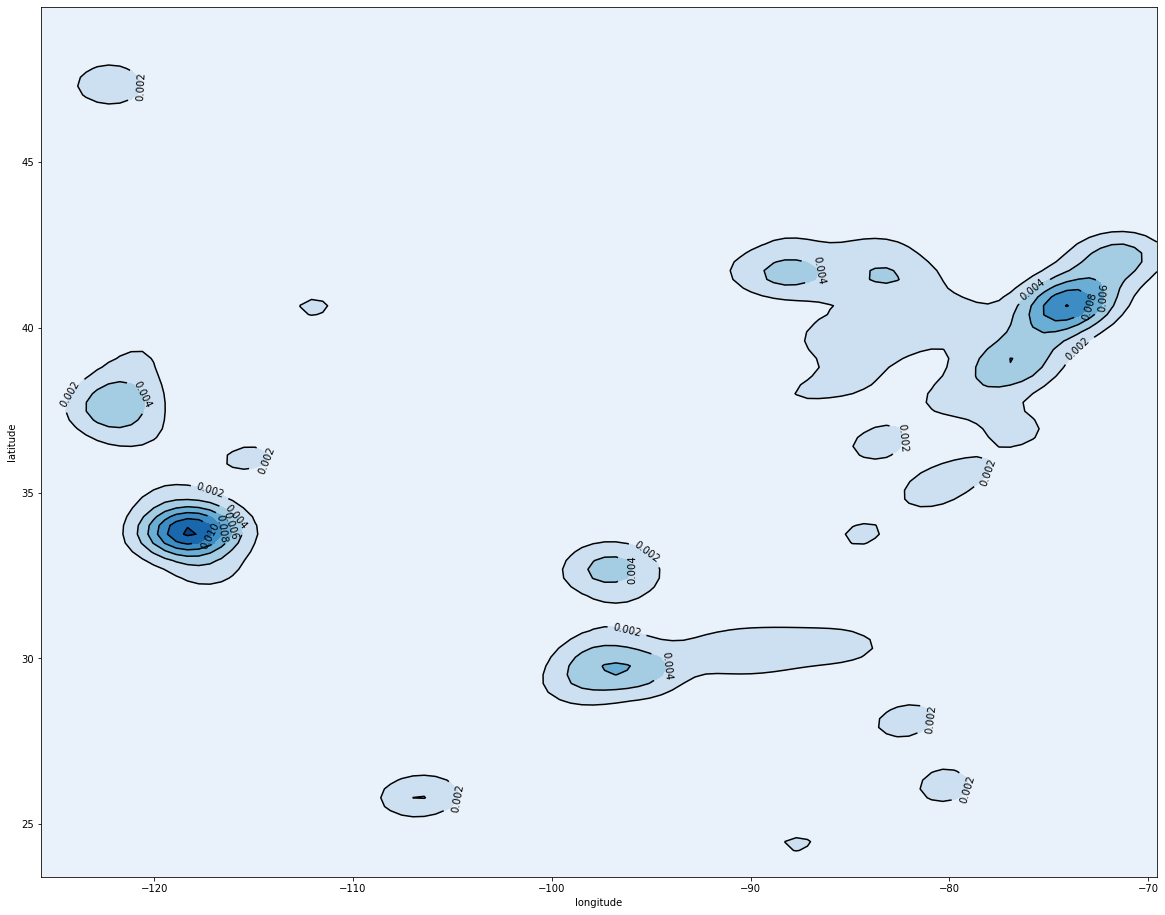

In [176]:
import scipy.stats as st

date = datetime(2018,2,2).date()
#record the data.
x = health_df_restricted[health_df_restricted['date'] == date]['lon']
y = health_df_restricted[health_df_restricted['date'] == date]['lat']
xmin, xmax = min(x)-1, max(x)+1
ymin, ymax = min(y)-1, max(y)+1

# Set up the grid for kernel density estimation
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x,y])
kernel = st.gaussian_kde(values, bw_method=0.1)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(20,16))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
 
pl.show()

# Can we turn the above into an animation for all the days of there?
*Or, we can just look at how these topics change from month to month...that might give us all the information we need
for seeing how the distribution of topics changes over time.*

In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)



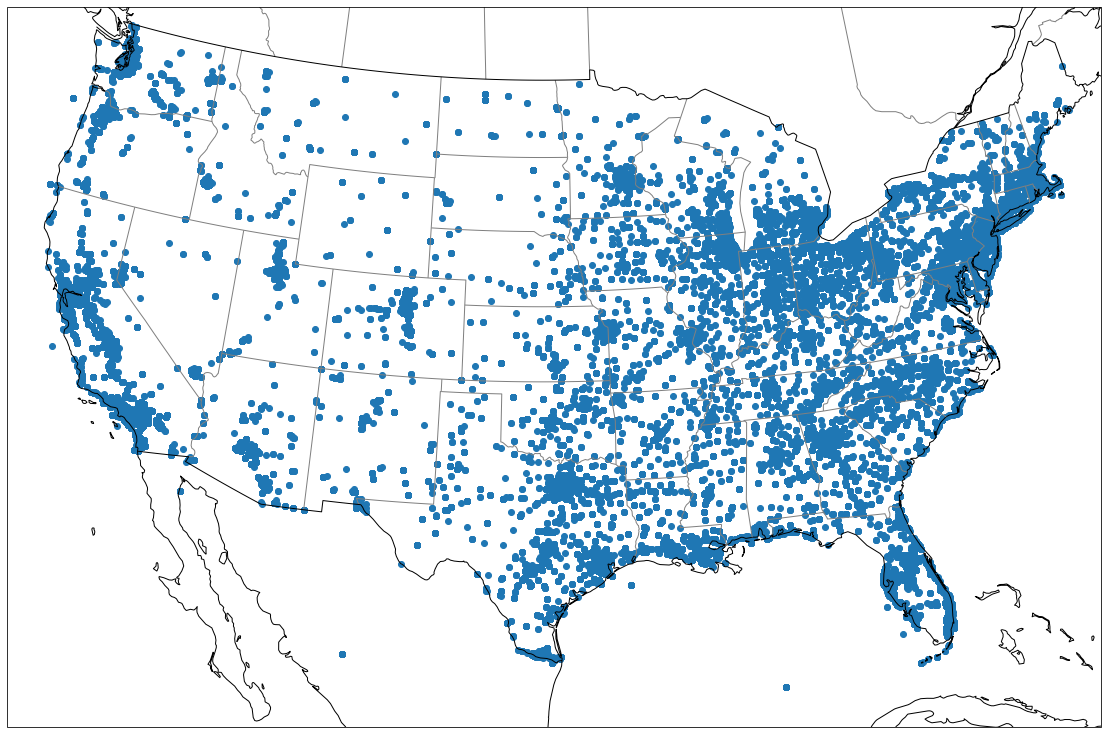

In [135]:
# This is just an example to show the tweets plotted over time.

import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(health_df['lon'],health_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

In [104]:
ca_health_df['lon']

4       -124.482003
10      -117.371882
20      -121.151704
21      -117.899428
34      -118.370320
            ...    
17147   -120.110397
17150   -122.035311
17151   -117.985941
17153   -119.284524
17168   -115.212251
Name: lon, Length: 35659, dtype: float64